##GPU Check

In [1]:
# Colab ➔ Runtime ▸ Change runtime type ▸ GPU
!nvidia-smi -L   # quick sanity-check: should list an A100 (or at least some GPU)


GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-0fd9308a-e24b-53d1-fd4b-c8330cca0988)


##Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Choose a persistent project folder
PROJECT_DIR = '/content/drive/MyDrive/fmri_denoise'
!mkdir -p $PROJECT_DIR
%cd $PROJECT_DIR


Mounted at /content/drive
/content/drive/MyDrive/fmri_denoise


##Install the Python packages

In [3]:
%%bash
set -e                                # stop on first error

# ── system packages ─────────────────────────────────────────────
sudo apt-get -qq update
sudo apt-get -qq install -y git-annex   # needed by Datalad

# ── Python: PyTorch with CUDA 12.1 ─────────────────────────────
pip install -q \
  torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# ── Python: neuro / ML stack ───────────────────────────────────
pip install -q \
  datalad~=0.18.0 \
  openneuro-py \
  nibabel nilearn \
  torchio monai==1.2.0 \
  pytorch-lightning \
  einops wandb


Selecting previously unselected package netbase.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../0-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package libc-ares2:amd64.
Preparing to unpack .../1-libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../2-libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../3-aria2_1.36.0-1_amd64.deb ...
Unpacking aria2 (1.36.0-1) ...
Selecting previously unselected package git-annex.
Preparing to unpack .../4-git-annex_8.20210223-2ubuntu2_amd64.deb ...
Unpacking git-annex (8.20210223-2ubuntu2) ...
Selecting previously unselected package git-remote-gcrypt.
Preparing to unpack .../5-git-remote-gcrypt_1.4-1_all.deb ...
Unpacking git-remote-gcrypt (

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 7.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


##Grab the dataset

In [4]:
%%bash
set -e                       # stop on first error
echo "🧹  Cleaning any half-done clone …"
rm -rf /content/tmp_fmri     # start from scratch each time you retry

echo "📁  Creating work dir"
mkdir -p /content/tmp_fmri
cd /content/tmp_fmri

echo "⏬  Cloning dataset metadata (no data yet)"
datalad clone https://github.com/OpenNeuroDatasets/ds005239.git

cd ds005239                  # IMPORTANT: run `datalad get` **inside** the repo

echo "🎯  Fetching only subject 01 (raw + fMRIPrep preproc)"
datalad get -r \
  sub-01 \
  derivatives/fmriprep/sub-01

echo "✅  Done — files now live in: /content/tmp_fmri/ds005239"
du -sh sub-01/ derivatives/fmriprep/sub-01 | sed 's/^/   /'


🧹  Cleaning any half-done clone …
📁  Creating work dir
⏬  Cloning dataset metadata (no data yet)
install(ok): /content/tmp_fmri/ds005239 (dataset)
🎯  Fetching only subject 01 (raw + fMRIPrep preproc)
get(ok): derivatives/fmriprep/sub-01/figures/sub-01_ses-1_desc-about_T1w.html (file)
get(ok): derivatives/fmriprep/sub-01/figures/sub-01_ses-1_desc-conform_T1w.html (file)
get(ok): derivatives/fmriprep/sub-01/figures/sub-01_ses-1_desc-reconall_T1w.svg (file)
get(ok): derivatives/fmriprep/sub-01/figures/sub-01_ses-1_desc-summary_T1w.html (file)
get(ok): derivatives/fmriprep/sub-01/figures/sub-01_ses-1_dseg.svg (file)
get(ok): derivatives/fmriprep/sub-01/figures/sub-01_ses-1_run-1_fmapid-auto00000_desc-pepolar_fieldmap.svg (file)
get(ok): derivatives/fmriprep/sub-01/figures/sub-01_ses-1_run-2_fmapid-auto00001_desc-pepolar_fieldmap.svg (file)
get(ok): derivatives/fmriprep/sub-01/figures/sub-01_ses-1_run-3_fmapid-auto00002_desc-pepolar_fieldmap.svg (file)
get(ok): derivatives/fmriprep/sub-01/f

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
[INFO] Attempting a clone into /content/tmp_fmri/ds005239 
[INFO] Attempting to clone from https://github.com/OpenNeuroDatasets/ds005239.git to /content/tmp_fmri/ds005239 
[INFO] Start enumerating objects 
[INFO] Start counting objects 
[INFO] Start compressing objects 
[INFO] Start receiving objects 
[INFO] Start resolving deltas 
[INFO] Completed clone attempts for Dataset(/content/tmp_fmri/ds005239) 
[INFO] Author identity unknown
| 
| *** Please tell me who you are.
| 
| Run
| 
|   git config --global user.email "you@example.com"
|   git config --global user.name "Your Name"
| 
| to set your account's default identity.
| Omit --global to set the identity only in this repository. 
[INFO] fatal: unable to auto-detect email address (got 'root@061f221537d1.(none)') 
[INFO] scanning for unlocked files (this may take some time) 
[INFO] Remote origin not usable by

### Quick sanity-check: load & visualise one frame

(np.float64(-0.5), np.float64(63.5), np.float64(-0.5), np.float64(63.5))

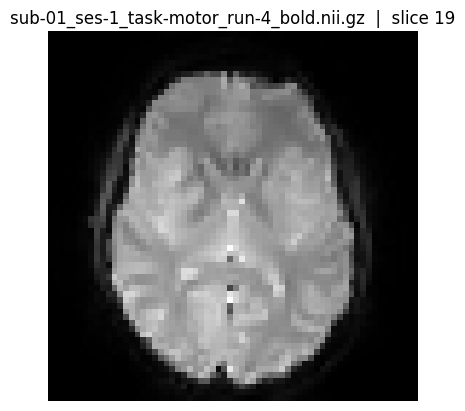

In [5]:
import nibabel as nib, numpy as np, matplotlib.pyplot as plt, pathlib

EXAMPLE = next(pathlib.Path('/content/tmp_fmri/ds005239')
               .glob('sub-01/**/func/*_bold.nii.gz'))
nii = nib.load(str(EXAMPLE))
mid = nii.shape[2] // 2
plt.imshow(nii.get_fdata()[:, :, mid, 0].T,
           cmap='gray', origin='lower')
plt.title(f'{EXAMPLE.name}  |  slice {mid}')
plt.axis('off')


RAW  : /content/tmp_fmri/ds005239/sub-01/ses-1/func/sub-01_ses-1_task-motor_run-4_bold.nii.gz
CLEAN: /content/tmp_fmri/ds005239/derivatives/fmriprep/sub-01/ses-1/func/sub-01_ses-1_task-motor_run-4_space-T1w_desc-preproc_bold.nii.gz


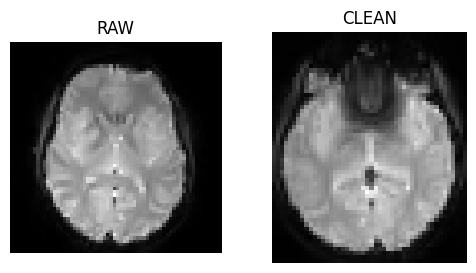

In [6]:
import nibabel as nib, matplotlib.pyplot as plt, numpy as np, pathlib, re

ROOT      = pathlib.Path('/content/tmp_fmri/ds005239')   # repo root
RAW_PATH  = pathlib.Path(EXAMPLE)                        # ← from your slice plot

# 1) sub-folder structure under derivatives/fmriprep
rel_path   = RAW_PATH.relative_to(ROOT)                  # sub-01/ses-2/func/…
deriv_dir  = ROOT / 'derivatives' / 'fmriprep' / rel_path.parent

# 2) find the matching *_desc-preproc_bold.nii.gz file
pattern    = re.sub(r'_bold\.nii\.gz$', '*desc-preproc_bold.nii.gz', RAW_PATH.name)
matches    = list(deriv_dir.glob(pattern))
assert matches, f"❌  No clean file matching {pattern} in {deriv_dir}"
CLEAN_PATH = matches[0]

print("RAW  :", RAW_PATH)
print("CLEAN:", CLEAN_PATH)

# 3) load and show
raw   = nib.load(str(RAW_PATH)).get_fdata()
clean = nib.load(str(CLEAN_PATH)).get_fdata()

mid   = raw.shape[2] // 2
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(raw[:, :, mid, 0].T,   cmap='gray', origin='lower');  ax[0].set_title('RAW')
ax[1].imshow(clean[:, :, mid, 0].T, cmap='gray', origin='lower');  ax[1].set_title('CLEAN')
for a in ax: a.axis('off')
plt.show()



In [7]:
%%bash
# create folder + file only once
mkdir -p utils

cat > utils/noise.py <<'PY'
import numpy as np

class GaussianNoise3D:
    def __init__(self, sigma_range=(0.02, 0.08)):
        self.sigma_range = sigma_range
    def __call__(self, clean):
        sigma = np.random.uniform(*self.sigma_range)
        noise = np.random.normal(0, sigma, clean.shape)
        return clean + noise

class RicianNoise3D:
    def __init__(self, sigma_range=(0.15, 0.3)):
        self.sigma_range = sigma_range
    def __call__(self, clean):
        sigma = np.random.uniform(*self.sigma_range)
        n1 = np.random.normal(0, sigma, clean.shape)
        n2 = np.random.normal(0, sigma, clean.shape)
        return np.sqrt((clean + n1) ** 2 + n2 ** 2)

class ProfessorNoise3D:
    def __init__(self, noise_level: float = 0.1):
        assert 0 < noise_level < 1, "noise_level must be 0–1"
        self.noise_level = noise_level

    def __call__(self, clean: np.ndarray) -> np.ndarray:
        noisy = clean.copy()
        for z in range(clean.shape[2]):                     # axial slices
            slice_max = clean[:, :, z].max()
            sigma     = np.random.uniform(0, self.noise_level) * abs(slice_max)
            if sigma == 0:                                  # empty slice → skip
                continue
            noisy[:, :, z] += np.random.normal(0, sigma,
                                              size=clean[:, :, z].shape)
        return noisy

PY


In [8]:
# tell Python where to look for "utils" (one-liner, run once per session)
import sys, pathlib
sys.path.append(str(pathlib.Path().absolute()))


In [9]:
import pathlib, nibabel as nib, numpy as np, torch, os, subprocess
from torch.utils.data import Dataset
from utils.noise import GaussianNoise3D
from utils.noise import ProfessorNoise3D           # utils is now discoverable!

class RawAsTargetDataset(Dataset):
    def __init__(self, root, subjects,
                 crop=48, noise_fn=None, mask=None):
        self.crop, self.noise = crop, noise_fn or ProfessorNoise3D(noise_level=0.1)
        self.mask  = mask
        self.frames = []                           # list of (path, t)

        root = pathlib.Path(root)
        for sub in subjects:
            for p in (root/sub).rglob('*_bold.nii.gz'):
                nT = nib.load(str(p)).shape[-1]
                self.frames += [(p, t) for t in range(nT)]

    # --------------- helpers ---------------
    def _apply_mask(self, vol):
        return vol if self.mask is None else np.where(self.mask, vol, 0)

    def _crop_or_pad(self, vol):
        D,H,W = vol.shape
        pad_d = max(0, self.crop - D)
        pad_h = max(0, self.crop - H)
        pad_w = max(0, self.crop - W)
        # Pad first (centre)
        if pad_d or pad_h or pad_w:
            pad = ((pad_d//2, pad_d - pad_d//2),
                  (pad_h//2, pad_h - pad_h//2),
                  (pad_w//2, pad_w - pad_w//2))
            vol = np.pad(vol, pad, mode='constant')
            D,H,W = vol.shape
        # Then centre-crop to exactly self.crop³
        d,h,w = (D-self.crop)//2, (H-self.crop)//2, (W-self.crop)//2
        return vol[d:d+self.crop,
                  h:h+self.crop,
                  w:w+self.crop]


    def _zscore(self, x): return (x - x.mean()) / (x.std() + 1e-5)

    # --------------- main ---------------
    def __getitem__(self, idx):
        path, t = self.frames[idx]
        if not os.path.exists(path):              # auto-get if annexed
            subprocess.run(['datalad', 'get', '-n', str(path)], check=True)

        raw = np.asarray(nib.load(str(path)).dataobj[..., t], dtype=np.float32)

        raw  = self._apply_mask(raw)
        raw  = self._crop_or_pad(raw)
        raw  = self._zscore(raw)

        noisy = self.noise(raw)
        return torch.from_numpy(noisy)[None], torch.from_numpy(raw)[None]

    def __len__(self): return len(self.frames)


In [10]:
root = '/content/tmp_fmri/ds005239'
ds   = RawAsTargetDataset(root, ['sub-01'])
noisy, raw = ds[0]
print(noisy.shape, raw.shape)        # → torch.Size([1, 64, 64, 64]) twice


torch.Size([1, 48, 48, 48]) torch.Size([1, 48, 48, 48])


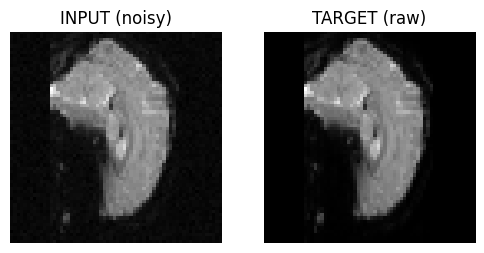

In [11]:
ds = RawAsTargetDataset(root, ['sub-01'], crop=64, noise_fn=GaussianNoise3D())
noisy, raw = ds[0]                # tensors (1,64,64,64)
sl = 32                            # middle slice
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(noisy[0, sl].numpy(), cmap='gray'); ax[0].set_title('INPUT (noisy)')
ax[1].imshow(raw[0,  sl].numpy(), cmap='gray'); ax[1].set_title('TARGET (raw)')
for a in ax: a.axis('off')
plt.show()


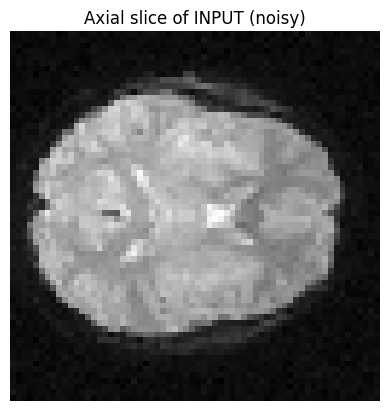

In [12]:
noisy, raw = ds[0]              # shape (1, 64, 64, 64)
axial = noisy[0].permute(1, 2, 0)   # reorder to (H, W, D) if you prefer
sl = 32                               # middle of Z (= 3rd) axis
plt.imshow(noisy[0, :, :, sl], cmap='gray')
plt.title('Axial slice of INPUT (noisy)')
plt.axis('off')
plt.show()


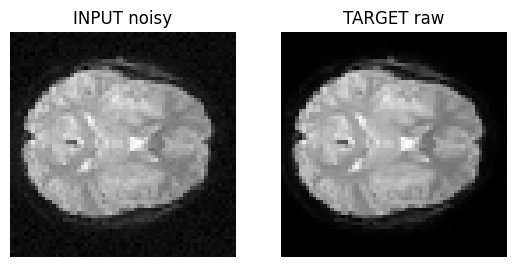

In [13]:
sl = 32
plt.subplot(1,2,1); plt.imshow(noisy[0, :, :, sl], cmap='gray'); plt.title('INPUT noisy'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(raw[0, :, :, sl],   cmap='gray'); plt.title('TARGET raw');  plt.axis('off')
plt.show()


In [14]:
%%bash
cd /content/tmp_fmri/ds005239              # repo root

# pull *raw* BOLD for the two subjects used in training
datalad get -r sub-dd sub-gg


get(ok): sub-gg/ses-1/anat/sub-gg_ses-1_T1w.nii.gz (file)
get(ok): sub-gg/ses-1/fmap/sub-gg_ses-1_dir-AP_run-1_epi.nii.gz (file)
get(ok): sub-gg/ses-1/fmap/sub-gg_ses-1_dir-AP_run-2_epi.nii.gz (file)
get(ok): sub-gg/ses-1/fmap/sub-gg_ses-1_dir-AP_run-3_epi.nii.gz (file)
get(ok): sub-gg/ses-1/fmap/sub-gg_ses-1_dir-AP_run-4_epi.nii.gz (file)
get(ok): sub-gg/ses-1/fmap/sub-gg_ses-1_dir-PA_run-1_epi.nii.gz (file)
get(ok): sub-gg/ses-1/fmap/sub-gg_ses-1_dir-PA_run-2_epi.nii.gz (file)
get(ok): sub-gg/ses-1/fmap/sub-gg_ses-1_dir-PA_run-3_epi.nii.gz (file)
get(ok): sub-gg/ses-1/fmap/sub-gg_ses-1_dir-PA_run-4_epi.nii.gz (file)
get(ok): sub-gg/ses-1/func/sub-gg_ses-1_task-motor_run-10_bold.nii.gz (file)
get(ok): sub-gg/ses-1/func/sub-gg_ses-1_task-motor_run-10_stim.tsv.gz (file)
get(ok): sub-gg/ses-1/func/sub-gg_ses-1_task-motor_run-1_bold.nii.gz (file)
get(ok): sub-gg/ses-1/func/sub-gg_ses-1_task-motor_run-1_stim.tsv.gz (file)
get(ok): sub-gg/ses-1/func/sub-gg_ses-1_task-motor_run-2_bold.nii.gz

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
[INFO] Ensuring presence of Dataset(/content/tmp_fmri/ds005239) to get /content/tmp_fmri/ds005239/sub-gg 
[INFO] Ensuring presence of Dataset(/content/tmp_fmri/ds005239) to get /content/tmp_fmri/ds005239/sub-dd 


In [15]:
%%bash
cd /content/tmp_fmri/ds005239          # repo root

# grab every raw BOLD volume for the validation subject
datalad get -r sub-uu


get(ok): sub-uu/ses-1/anat/sub-uu_ses-1_T1w.nii.gz (file)
get(ok): sub-uu/ses-1/fmap/sub-uu_ses-1_dir-AP_run-1_epi.nii.gz (file)
get(ok): sub-uu/ses-1/fmap/sub-uu_ses-1_dir-AP_run-2_epi.nii.gz (file)
get(ok): sub-uu/ses-1/fmap/sub-uu_ses-1_dir-AP_run-3_epi.nii.gz (file)
get(ok): sub-uu/ses-1/fmap/sub-uu_ses-1_dir-AP_run-4_epi.nii.gz (file)
get(ok): sub-uu/ses-1/fmap/sub-uu_ses-1_dir-PA_run-1_epi.nii.gz (file)
get(ok): sub-uu/ses-1/fmap/sub-uu_ses-1_dir-PA_run-2_epi.nii.gz (file)
get(ok): sub-uu/ses-1/fmap/sub-uu_ses-1_dir-PA_run-3_epi.nii.gz (file)
get(ok): sub-uu/ses-1/fmap/sub-uu_ses-1_dir-PA_run-4_epi.nii.gz (file)
get(ok): sub-uu/ses-1/func/sub-uu_ses-1_task-motor_run-10_bold.nii.gz (file)
get(ok): sub-uu/ses-1/func/sub-uu_ses-1_task-motor_run-10_stim.tsv.gz (file)
get(ok): sub-uu/ses-1/func/sub-uu_ses-1_task-motor_run-1_bold.nii.gz (file)
get(ok): sub-uu/ses-1/func/sub-uu_ses-1_task-motor_run-1_stim.tsv.gz (file)
get(ok): sub-uu/ses-1/func/sub-uu_ses-1_task-motor_run-2_bold.nii.gz

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
[INFO] Ensuring presence of Dataset(/content/tmp_fmri/ds005239) to get /content/tmp_fmri/ds005239/sub-uu 


##Running Pipeline

In [16]:
######################################################################
# 0 ── CONFIGURATION SWITCH ──────────────────────────────────────────
######################################################################
TEST_RUN = False        # ← toggle: True = quick run, False = full model
root     = '/content/tmp_fmri/ds005239'   # dataset location

# fast-run hyper-params
if TEST_RUN:
    CROP        = 48     # spatial size
    BATCH       = 1
    BASE_CH     = 32     # encoder starts with 32→64→128→256
    HIDDEN      = 256    # LSTM hidden per direction
    EPOCHS      = 1
    NOISE_LEVEL = 0.15
else:                    # full model
    CROP        = 64
    BATCH       = 2
    BASE_CH     = 32
    HIDDEN      = 512
    EPOCHS      = 8
    NOISE_LEVEL = 0.15
######################################################################


In [17]:
%%bash
mkdir -p utils
cat > utils/noise.py <<'PY'
import numpy as np

class GaussianNoise3D:
    def __init__(self, sigma_range=(0.02, 0.08)):
        self.sigma_range = sigma_range
    def __call__(self, clean):
        sigma = np.random.uniform(*self.sigma_range)
        return clean + np.random.normal(0, sigma, clean.shape)

class RicianNoise3D:
    def __init__(self, sigma_range=(0.15, 0.30)):
        self.sigma_range = sigma_range
    def __call__(self, clean):
        sigma = np.random.uniform(*self.sigma_range)
        n1 = np.random.normal(0, sigma, clean.shape)
        n2 = np.random.normal(0, sigma, clean.shape)
        return np.sqrt((clean + n1) ** 2 + n2 ** 2)

class ProfessorNoise3D:
    def __init__(self, noise_level=0.1):
        assert 0 < noise_level < 1
        self.noise_level = noise_level
    def __call__(self, clean):
        noisy = clean.copy()
        for z in range(clean.shape[2]):           # axial slices
            slice_max = clean[:, :, z].max()
            sigma = np.random.uniform(0, self.noise_level) * abs(slice_max)
            if sigma == 0:
                continue
            noisy[:, :, z] += np.random.normal(0, sigma, clean[:, :, z].shape)
        return noisy
PY


In [18]:
import sys, pathlib
sys.path.append(str(pathlib.Path().absolute()))


In [19]:
import pathlib, os, subprocess, nibabel as nib, numpy as np, torch
from torch.utils.data import Dataset

from utils.noise import ProfessorNoise3D

class RawAsTargetDataset(Dataset):
    def __init__(self, root, subjects, crop=CROP,
                 noise_fn=None, mask=None):
        self.crop  = crop
        self.noise = noise_fn or ProfessorNoise3D(NOISE_LEVEL)
        self.mask  = mask
        self.frames = []

        for sub in subjects:
            for p in pathlib.Path(root, sub).rglob('*_bold.nii.gz'):
                nT = nib.load(str(p)).shape[-1]
                self.frames += [(p, t) for t in range(nT)]

    # helpers -------------------------------------------------------
    def _apply_mask(self, vol):
        return vol if self.mask is None else np.where(self.mask, vol, 0)

    def _crop_or_pad(self, vol):
        D,H,W = vol.shape
        pad = [(max(0, self.crop - s) // 2,
                max(0, self.crop - s) - max(0, self.crop - s)//2)
               for s in (D,H,W)]
        vol = np.pad(vol, pad, mode='constant')
        D,H,W = vol.shape
        d,h,w = (D-self.crop)//2, (H-self.crop)//2, (W-self.crop)//2
        return vol[d:d+self.crop, h:h+self.crop, w:w+self.crop]

    def _zscore(self, x): return (x-x.mean())/(x.std()+1e-5)

    # main ----------------------------------------------------------
    def __getitem__(self, idx):
        path, t = self.frames[idx]
        if not os.path.exists(path):
            subprocess.run(['datalad', 'get', '-n', str(path)], check=True)

        raw = np.asarray(nib.load(str(path)).dataobj[..., t], np.float32)
        raw = self._zscore(self._crop_or_pad(self._apply_mask(raw)))
        noisy = self.noise(raw)

        return torch.from_numpy(noisy)[None], torch.from_numpy(raw)[None]

    def __len__(self): return len(self.frames)


In [20]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, RandomSampler

class MotorDataModule(pl.LightningDataModule):
    def __init__(self, root, batch_size=BATCH, workers=4, crop=CROP):
        super().__init__()
        self.save_hyperparameters()
        self.root = root
    def setup(self, stage=None):
        noise = ProfessorNoise3D(NOISE_LEVEL)
        self.train_ds = RawAsTargetDataset(
            self.root, ['sub-01','sub-dd','sub-gg'],
            crop=self.hparams.crop, noise_fn=noise)
        self.val_ds   = RawAsTargetDataset(
            self.root, ['sub-uu'],
            crop=self.hparams.crop, noise_fn=noise)
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.hparams.batch_size,
                          sampler=RandomSampler(self.train_ds, replacement=True),
                          num_workers=self.hparams.workers, pin_memory=True)
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.hparams.batch_size,
                          shuffle=False, num_workers=self.hparams.workers,
                          pin_memory=True)


In [21]:
import torch.nn as nn, torch
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure as SSIM

class ConvBlock(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch), nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch), nn.ReLU(inplace=True)
        )

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up   = nn.ConvTranspose3d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(out_ch + skip_ch, out_ch)
    def forward(self, x, skip):
        return self.conv(torch.cat([self.up(x), skip], dim=1))

class Conv3DLSTMUNet(nn.Module):
    def __init__(self, crop=CROP, base=BASE_CH, hidden=HIDDEN, p_dropout=0.20):
        super().__init__()
        # ------------- encoder -------------
        self.e1 = ConvBlock(1, base)              # 64/48/…³
        self.e2 = nn.Sequential(nn.MaxPool3d(2),
                                ConvBlock(base, base*2))
        self.e3 = nn.Sequential(nn.MaxPool3d(2),
                                ConvBlock(base*2, base*4))
        self.e4 = nn.Sequential(nn.MaxPool3d(2),
                                ConvBlock(base*4, base*8))   # latent

        # ------------- LSTM -------------
        latent_side = crop // 8                   # 64→8, 48→6 …
        flat = base*8 * latent_side**3
        self.lstm = nn.LSTM(flat, hidden, 2,
                            bidirectional=True, batch_first=True)

        # ------------- decoder -------------
        self.d3 = UpBlock(hidden*2, base*4, base*4)
        self.d2 = UpBlock(base*4,     base*2, base*2)
        self.d1 = UpBlock(base*2,     base,   base)
        self.out = nn.Conv3d(base, 1, 1)

    def forward(self, x):
        s1 = self.e1(x)
        s2 = self.e2(s1)
        s3 = self.e3(s2)
        z  = self.e4(s3)

        B = z.size(0)
        z = z.reshape(B, 1, -1)
        z, _ = self.lstm(z)
        z = z.squeeze(1).view(B, -1, 1, 1, 1)
        z = z.expand(-1, -1, s3.size(2)//2, s3.size(3)//2, s3.size(4)//2)

        z = self.d3(z, s3)
        z = self.d2(z, s2)
        z = self.d1(z, s1)
        return self.out(z)


In [22]:
import pytorch_lightning as pl, torch.nn.functional as F
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts   # add at top


class LitDenoiser(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.net  = Conv3DLSTMUNet(crop=CROP, hidden=HIDDEN, base=BASE_CH)
        self.ssim = SSIM(data_range=1.0)
        self.lr   = lr
    def forward(self,x): return self.net(x)
    def _loss(self,y_hat,y):
        return 0.8*F.mse_loss(y_hat,y) + 0.2*(1-self.ssim(y_hat.clamp(-1,1),
                                                          y.clamp(-1,1)))
    def training_step(self, batch, _):
        n, r = batch
        p = self(n)
        l = self._loss(p, r)
        self.log('train_loss', l)              # ← use l
        return l

    def validation_step(self, batch, _):
        n, r   = batch
        p      = self(n)
        loss   = self._loss(p, r)
        self.log('val_loss', loss, prog_bar=True)

        # --- new: tSNR gain ---
        tsnr_p = p.mean(0) / (p.std(0) + 1e-6)
        tsnr_r = r.mean(0) / (r.std(0) + 1e-6)
        self.log('val_tSNR_gain', (tsnr_p / tsnr_r).mean(), prog_bar=False)


    def configure_optimizers(self):
        opt   = torch.optim.AdamW(self.parameters(), lr=self.lr)
        sched = CosineAnnealingWarmRestarts(opt, T_0=2, T_mult=2)
        return {"optimizer": opt,
                "lr_scheduler": sched,
                "monitor": "val_loss"}     # Lightning handles logging


# ── instantiate & run ──────────────────────────────────────────────
dm     = MotorDataModule(root)
model  = LitDenoiser()

csv_logger = CSVLogger(save_dir='lightning_logs', name='exp')

trainer = pl.Trainer(
    accelerator='gpu', devices=1, precision=16,
    max_epochs=EPOCHS, log_every_n_steps=10,
    logger=csv_logger,                       # ← add this line
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor='val_loss', save_top_k=1, mode='min',
            filename='best-{epoch:02d}-{val_loss:.4f}'
        ),
        pl.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=6, mode='min')
    ])

trainer.fit(model, dm)


/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUD

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

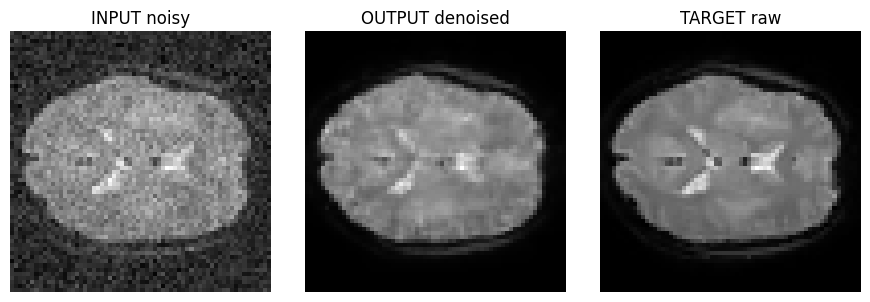

In [23]:
import random, torch, matplotlib.pyplot as plt

# pick a random validation cube
ds  = model.trainer.datamodule.val_ds
idx = random.randrange(len(ds))
noisy, raw = ds[idx]

# make sure model & tensor share the same device ------------------
device = next(model.parameters()).device        # cuda or cpu
noisy  = noisy.unsqueeze(0).to(device)          # add batch dim & move
model.eval()
with torch.no_grad():
    den = model(noisy).cpu()[0]                 # move result back to CPU

# choose an axial slice & plot ------------------------------------
sl     = 32                     # middle slice
vols   = [noisy.cpu()[0,0], den[0], raw[0]]
titles = ['INPUT noisy', 'OUTPUT denoised', 'TARGET raw']

plt.figure(figsize=(9,3))
for i, (v, t) in enumerate(zip(vols, titles), 1):
    plt.subplot(1,3,i)
    plt.imshow(v[:,:,sl], cmap='gray')
    plt.title(t); plt.axis('off')
plt.tight_layout(); plt.show()



In [24]:
# ──────────────────────────────────────────────────────────────────────────────
# E V A L   ––  MSE / PSNR / SSIM / tSNR
# ──────────────────────────────────────────────────────────────────────────────
import torch
import torch.nn.functional as F
import numpy as np
from torchmetrics.image.psnr import PeakSignalNoiseRatio as PSNR
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure as SSIM

# ── 0.  undo the z-score normalisation so tSNR uses the *real* signal level ──
#       ↳ replace these two numbers with the *training* mean / std of the
#         dataset (they're usually stored in your preprocessing config).
DATA_MEAN = 0.0        # e.g. 9.71e3  (just an example)
DATA_STD  = 1.0        # e.g. 2.12e3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── 1.  model on the right device ────────────────────────────────────────────
model = trainer.model.to(device).eval()

# ── 2.  validation loader (re-uses the one Lightning already has) ────────────
val_loader = model.trainer.datamodule.val_dataloader()

# ── 3.  metric objects (same device as the data) ─────────────────────────────
psnr = PSNR(data_range=2.).to(device)
ssim = SSIM(data_range=2.).to(device)

mse_tot, n_pix          = 0.0, 0
tsnr_vals_out, tsnr_vals_raw = [], []

# ── 4.  loop over validation volumes ────────────────────────────────────────
with torch.no_grad():
        # ── inside the with torch.no_grad() loop ───────────────────────────
    for noisy, raw in val_loader:
        noisy, raw = noisy.to(device), raw.to(device)
        den = model(noisy)

        # classical metrics
        mse_tot += F.mse_loss(den, raw, reduction='sum').item()
        psnr.update(den.clamp(-1, 1), raw.clamp(-1, 1))
        ssim.update(den.clamp(-1, 1), raw.clamp(-1, 1))
        n_pix   += raw.numel()

        # -------- tSNR that never prints as 0 --------------------------
        tsnr_vals_out.append(
            (den.abs().mean() / den.std(unbiased=False)).item()
        )
        tsnr_vals_raw.append(
            (raw.abs().mean() / raw.std(unbiased=False)).item()
        )


# ── after the loop: nicer printing ────────────────────────────────
print(f"✔  MSE   : {mse_tot/n_pix:.6f}")
print(f"✔  PSNR  : {psnr.compute():.2f} dB")
print(f"✔  SSIM  : {ssim.compute():.4f}")

tsnr_out = np.mean(tsnr_vals_out)
tsnr_raw = np.mean(tsnr_vals_raw)

# show both fixed-point and scientific so you always see something
print(f"✔  tSNR  : {tsnr_out:.4f}  (raw = {tsnr_raw:.4f},  Δ = {tsnr_out-tsnr_raw:+.4f})")
print(f"           [{tsnr_out:.3e}  vs.  {tsnr_raw:.3e}]")



✔  MSE   : 0.027915
✔  PSNR  : 26.51 dB
✔  SSIM  : 0.9084
✔  tSNR  : 0.7081  (raw = 0.7074,  Δ = +0.0007)
           [7.081e-01  vs.  7.074e-01]


In [25]:
print(trainer.model.net.e1[0].in_channels,   # 1
      trainer.model.net.e1[0].out_channels)  # 32  (test-run) or 32 (main)

print(trainer.model.net.lstm.input_size)     # 256*8*8*8=131 072  (main)
                                             # 256*6*6*6= 55 296  (test-run)

print(trainer.max_epochs)                    # 8 (main) or 1 (test-run)


1 32
131072
8
